# Topic Classification

Below is an example working with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Here we'll represent each document with a "bag-of-words" model. This makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *


import nltk

#Karthik NLTK
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

#Kartihk UTILITIES
import string


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
## STUDENT START ###

    #Built a Pandas DF with num_exampe entries
    d = {'text': train_data[0:num_examples], 'label': train_labels[0:num_examples]}
    train_examples = pd.DataFrame(data=d)
    
    #Iterate through rows and print data
    for index, row in train_examples.iterrows():
        print("Label: {0}".format(newsgroups_train.target_names[row['label']]))
        print()
        print(row['text'])
        print()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
    
    #Return dataframe of num_examples size
    return train_examples
    
## STUDENT END ###
p1_examples = P1()

Label: comp.graphics

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Label: talk.religion.misc



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil

### Part 2:

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
    
    # Could include this option to ignore basic stop words throughout the text
    # stop_words='english'    
    
    global_vectorizer = CountVectorizer(lowercase=True)
    # global_vectorizer = CountVectorizer(lowercase=True, token_pattern = "^[^0-9]+$")
    global_vtrain = global_vectorizer.fit_transform(train_data)
    sparse_matrix = global_vtrain.toarray()
    
    print ("Train Data Matrix Shape:  {0}".format(global_vtrain.shape))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print()
    
    
    def a():
        
        print( "PART A:")
        print()
        
        vocab_size = len(global_vectorizer.get_feature_names())
        print ("Train Data Vocab Size:  {0}".format(vocab_size))
        print()
        
        avg_non_zero_per_entry = global_vtrain.nnz/global_vtrain.shape[0]
        print ("Average Number of Non-zero Features  {0}".format(avg_non_zero_per_entry))
        print()        
        
        total_slots = global_vtrain.shape[0] * global_vtrain.shape[1]
        full_slots = global_vtrain.nnz
        ratio = full_slots/ total_slots
        print ("Fraction of Non-zero Entries: {0}".format(ratio))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        
        
    def b():
        
        print( "PART B:")
        print()
        
        first_feature = global_vectorizer.get_feature_names()[0]
        last_feature = global_vectorizer.get_feature_names()[-1]
    
        print ("First feature: {0}".format(first_feature))
        print()
        print ("Last feature: {0}".format(last_feature))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        
        
        
    def c():

        print( "PART C:")
        print()
        

        own_vocab = ["atheism", "graphics", "space", "religion"]
        own_vectorizer = CountVectorizer(lowercase=True, vocabulary=own_vocab)
        own_vtrain = own_vectorizer.fit_transform(train_data)
        
        print("Custom Vocab:")
        print(own_vectorizer.vocabulary_)
        print()        
        print ("Own Vocab Matrix Shape: {0}".format(own_vtrain.shape))
        print()
        print ("Own Vocab Matrix: {0}".format(own_vtrain.toarray()))
        print()

        avg_non_zero_per_entry = own_vtrain.nnz/own_vtrain.shape[0]
        print ("Average Number of Non-zero Features  {0}".format(avg_non_zero_per_entry))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        

    def d():
        
        print( "PART D:")
        print()
        print("Bigram + Trigram on Character Features")
        
        vectorizer = CountVectorizer(lowercase=True, ngram_range= (2, 3), analyzer='char')
        vtrain = vectorizer.fit_transform(train_data)        
        
        vocab_size = len(vectorizer.get_feature_names())
        print ("Vocab Size:  {0}".format(vocab_size))
        print()
        print ("Vocab Matrix Shape: {0}".format(vtrain.shape))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        
        
    def e():
        
        print( "PART E:")
        print()
        print("min_df = 10 : Prune words that appear in fewer than 10 documents")
        print()
        
        vectorizer = CountVectorizer(lowercase=True, min_df=10)
        vtrain = vectorizer.fit_transform(train_data)        
        
        vocab_size = len(vectorizer.get_feature_names())
        print ("Vocab Size:  {0}".format(vocab_size))
        print()
        print ("Vocab Matrix Shape: {0}".format(vtrain.shape))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        
    def f():
        
        print( "PART F:")
        print()
        print("Dev Size vs. Train Size")
        print()
        
        dev_vectorizer = CountVectorizer(lowercase=True)
        dev_vtrain = dev_vectorizer.fit_transform(dev_data)
        
        dev_vocab = set(dev_vectorizer.get_feature_names())
        print ("Dev Vocab Size:  {0}".format(len(dev_vocab)))
        print()
        train_vocab = set(global_vectorizer.get_feature_names())
        print ("Train Vocab Size:  {0}".format(len(train_vocab)))
        print()
        
        print("Words in dev_data missing from train_data {0} words".format(len(dev_vocab - train_vocab)))
        print()
        print("This is {0}% of the dev_data".format(np.round(100*len(dev_vocab - train_vocab)/len(dev_vocab), 3)))
        print()    
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()        
                
    a()
    b()
    c()
    d()
    e()
    f()
        
P2()

Train Data Matrix Shape:  (2034, 26879)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

PART A:

Train Data Vocab Size:  26879

Average Number of Non-zero Features  96.70599803343165

Fraction of Non-zero Entries: 0.0035978272269590263
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

PART B:

First feature: 00

Last feature: zyxel
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

PART C:

Custom Vocab:
{'atheism': 0, 'graphics': 1, 'space': 2, 'religion': 3}

Own Vocab Matrix Shape: (2034, 4)

Own Vocab Matrix: [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]]

Average Number of Non-zero Features  0.26843657817109146
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

PART D:

Bigram + Trigram on Character Features
Vocab Size:  35478

Vocab Matrix Shape: (2034, 35478)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

PART E:

min_df = 10 : Prune words that appear in fewer than 10 documents

Vocab Size:  3064

Voca

### Part 3:

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score with average="weighted") for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

* Why doesn't nearest neighbors work well for this problem?
* Any ideas why logistic regression doesn't work as well as Naive Bayes?
* Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():

    #Common vectorizer
    vectorizer = CountVectorizer()
    
    #TRAINING
    sparse_train = vectorizer.fit_transform(train_data)
    
    #DEVELOPMENT
    sparse_dev = vectorizer.transform(dev_data)
    
    
    def knn():
        
        print()
        print("KNN MODEL:")
        print()        
        # Use GridSearch to try various values of hyper parameter "k"
        n_neighbors = {'n_neighbors': list(range(1,25,2))}
        knn_cv = GridSearchCV(estimator=KNeighborsClassifier(),
                                   param_grid=n_neighbors,
                                   cv=5,
                                   return_train_score=True)

        knn_cv.fit(sparse_train,train_labels)
        best_k = knn_cv.best_params_['n_neighbors']
        print("Best k value on range [1-25] :  {0}".format(best_k))
        print()
        
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(sparse_train,train_labels)
        train_predict = knn.predict(sparse_dev)
        
        
        f1_score = metrics.f1_score(dev_labels, train_predict, average="weighted")
        print()
        print("F1 Score (Weighted) {0}".format(f1_score))
        print()
        print("Classification Report for KNearestNeighbors with neighbors={0}".format(best_k))
        print(classification_report(dev_labels,train_predict))        
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        return f1_score
        
        
    def multi_naive_bayes():
        
        print()
        print("MULTINOMIAL NAIVE BAYES MODEL:")     
        print()
        # Use GridSearch to try various values of hyper parameter "alpha"
        alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
        multi_nb_cv = GridSearchCV(estimator=MultinomialNB(),
                                   param_grid=alphas,
                                   cv=5,
                                   return_train_score=True)

        multi_nb_cv.fit(sparse_train,train_labels)
        best_alpha = multi_nb_cv.best_params_['alpha']
        print("Best alpha value on range [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0] :  {0}".format(best_alpha))
        print()
        
        multi_nb = MultinomialNB(alpha=best_alpha)
        multi_nb.fit(sparse_train,train_labels)
        train_predict = multi_nb.predict(sparse_dev)
        f1_score = metrics.f1_score(dev_labels, train_predict, average="weighted")
        print()
        print("F1 Score (Weighted) {0}".format(f1_score))
        print()
        print("Classification Report for MultinomialNB with alpha={0}".format(best_alpha))
        print(classification_report(dev_labels,train_predict))        
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print() 
        return f1_score

    def log_reg():

        
        print()
        print("LOGISTIC REGRESSION MODEL:")     
        print()        
        
        param_grid = [
            {'penalty' : ['l2'],
             'multi_class': ["auto"],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['liblinear'],
            'max_iter' : [100, 1000,2500, 5000]
            }
        ]        
        
        # Use GridSearch to try various values of hyper parameter "c"
        # note: liblinear cannot be parallelized
        log_reg_cv = GridSearchCV(estimator=LogisticRegression(),
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  cv=5)

        log_reg_cv.fit(sparse_train,train_labels)
        
        print("Best Estimator {0}".format(log_reg_cv.best_estimator_))
        print()
        best_c = log_reg_cv.best_params_['C']
        print("Best \"C\" value on range [np.logspace(-4, 4, 20)] :  {0}".format(best_c))
        print()
        
        log_reg = LogisticRegression(C=best_c, multi_class="auto", solver='liblinear')
        log_reg.fit(sparse_train,train_labels)
        train_predict = log_reg.predict(sparse_dev)
        f1_score = metrics.f1_score(dev_labels, train_predict, average="weighted")
        print()
        print("F1 Score (Weighted) {0}".format(f1_score))
        print()
        print("Classification Report for LogisticRegression with C={0}".format(best_c))
        print(classification_report(dev_labels,train_predict))        
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        
    
        class_coeffs = log_reg.coef_
        
        output = {}
        
        for index,class_weights in enumerate(class_coeffs):
            sum_square = np.sum(np.square(class_weights))
            output[newsgroups_train.target_names[index]] = sum_square
            
        return [f1_score,output]
    
    knn_score = knn()
    multi_nb_score = multi_naive_bayes()
    log_reg_score, output = log_reg()
    
    score_d = {"knn":knn_score, "multi_nb_score": multi_nb_score, "log_reg_score": log_reg_score }
    print()
    print("Summary F1 Scores:")
    print(score_d)
    
    return output


log_reg_out = P3()


KNN MODEL:

Best k value on range [1-25] :  19


F1 Score (Weighted) 0.4365794782510113

Classification Report for KNearestNeighbors with neighbors=19
              precision    recall  f1-score   support

           0       0.38      0.50      0.43       165
           1       0.47      0.48      0.48       185
           2       0.55      0.49      0.52       199
           3       0.31      0.23      0.26       127

    accuracy                           0.44       676
   macro avg       0.43      0.42      0.42       676
weighted avg       0.44      0.44      0.44       676

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MULTINOMIAL NAIVE BAYES MODEL:

Best alpha value on range [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0] :  0.01


F1 Score (Weighted) 0.7751663218544357

Classification Report for MultinomialNB with alpha=0.01
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       165
           1       0.9

**Notes:**


**Why doesn't nearest neighbors work well for this problem?**

- GridSearchCV determines that K=19 is the optimal value, though this is on the high end! One major drawback of KNN is that it doesn't perform well when the dimension of your data is very high (i.e. you have a lot of features). In our case here each feature vector has 26,879 features. The dimensionality of the feature space grows, but it becomes very sparse. Due to this sparsity, it becomes much easier to find a separable hyperplane because the likelihood that a training sample lies on the wrong side of the best hyperplane becomes infinitely small. However, when this highly dimensional classification is projected back to a lower dimensional space, there would be a high level of overfitting of the model to the training data. The model would learn the training data too well and not perform well on new data.

<em>"In other words, if the amount of available training data is fixed, then overfitting occurs if we keep adding dimensions. On the other hand, if we keep adding dimensions, the amount of training data needs to grow exponentially fast to maintain the same coverage and to avoid overfitting." </em>

-- Source: https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/#comment-241

- A last point here is that KNN works off distance in the feature vectors, our representation of text is a binary array of 1's and 0's as flags for the existance of words. For example the meaning associated with two sentences talking about the same topic, though the two sentences have no common words, could be considered two very different vectors on the vector space with a potentially large distance between. Hence they would not be "neighbors". A simple example, "Your house is so beautiful" vs. "The place you live is aesthetic".

For the above reasons, we can see that KNN is not the best solution for our classification.

--------------------------------------------------------------------------------------------------------------


**Any ideas why logistic regression doesn't work as well as Naive Bayes?**

In our case here the amount of samples we train on and test on is not that large (~2000 samples). Naive bayes is built off the assumption that each feature is conditionally independent, while logistic regression is trying to calculate correlations amongst the features which then go into the odds function that ultimately determines the class. Because our feature vectors are so large, and that we are trying to represent text data, in translation it is difficult to capture all the correlations between words in lengthy somewhat sparse vectors.

Generally logistic regression would perform better than naive bayes with a larger dataset size, though this does not take away from the fundamental independence assumptions that naive bayes operates on training with knowledge of the prior. 

-- Source https://www.quora.com/What-is-the-difference-between-logistic-regression-and-Naive-Bayes

--------------------------------------------------------------------------------------------------------------
**Briefly explain the relationship between the sum and the value of C.**


As the C regularization hyper parameter goes up the sum of squares value also increases. Though there can be a slight plateau that gets hit here.

In [6]:
#Smaller values have more regularization.
print("Sum of Squares value for optimal Logistic Regression model by class.")
log_reg_out

Sum of Squares value for optimal Logistic Regression model by class.


{'alt.atheism': 119.46448994413365,
 'comp.graphics': 95.71799894836894,
 'sci.space': 114.55234229232897,
 'talk.religion.misc': 103.82401728947232}

### Part 4:

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [7]:
def P4(bigram=False):
    
    #Common vectorizer
    
    if (bigram):
        vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
    else:
        vectorizer = CountVectorizer()        

    #TRAINING
    sparse_train = vectorizer.fit_transform(train_data)
    
    #DEVELOPMENT
    sparse_dev = vectorizer.transform(dev_data)
    
    
    #Get vocab
    vocab = vectorizer.vocabulary_
    
    log_reg = LogisticRegression(C=0.62, multi_class="auto", solver='liblinear')
    log_reg.fit(sparse_train,train_labels)
    class_coeffs = log_reg.coef_
    
    
    top_20_features_overall = []
    top5_by_class = {}
    
    for label, category in enumerate(class_coeffs,start=0):
        
        vals = np.array(category)
        
        #Get index of the top 5 greatest weights
        top5_indices = np.argpartition(vals, -5)[-5:]
        
        #sorted in ascending order
        top5_sorted_indices = top5_indices[np.argsort(vals[top5_indices])]

        #This will be in descending order by heaviest weight because we prepend
        top5_feature_names = []
        
        #Get the actual feature name via the index
        for ind in top5_sorted_indices:
            name = list(vocab.keys())[list(vocab.values()).index(ind)]
            top5_feature_names.insert(0, name)
                 
        #Add to dictionary so its easy to track top 5 by class
        top5_by_class[newsgroups_train.target_names[label]] = top5_feature_names
        
        #Add to total list of 20 features
        top_20_features_overall.extend(top5_feature_names)

    
    #Dictionary to print top 20 weights table
    top20_weights = {"feature_name": top_20_features_overall}
    
    
    #For each class/ category get the weights for top 20 features
    for label, category in enumerate(class_coeffs,start=0):
        weights_by_class = []
        for feature in top_20_features_overall:
            weights_by_class.append(category[vocab[feature]])
            
        top20_weights[newsgroups_train.target_names[label]] = weights_by_class
        

    #Overall Top 20 Features, by class
    top20_weights_df = pd.DataFrame.from_dict(top20_weights)
            
    #Top 5 Features in each class
    top5_df = pd.DataFrame.from_dict(top5_by_class)
        
    return [top5_df, top20_weights_df, top_20_features_overall]

p4_output = P4()
p4_bigram_output = P4(bigram=True)

In [8]:
print("5 features with the largest weights for by label")
p4_output[0]

5 features with the largest weights for by label


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,atheists,graphics,space,christians
1,bobby,image,orbit,christian
2,religion,file,nasa,blood
3,atheism,3d,launch,fbi
4,deletion,computer,spacecraft,order


In [9]:
print("Weights for each of these 20 features by label")
p4_output[1]

Weights for each of these 20 features by label


,feature_name,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,atheists,0.891670,-0.093994,-0.283623,-0.696254
1,bobby,0.874773,-0.200736,-0.303228,-0.410370
2,religion,0.845453,-0.541207,-0.698955,-0.056091
3,atheism,0.838674,-0.369886,-0.392319,-0.394050
4,deletion,0.830662,-0.288366,-0.311906,-0.303569
5,graphics,-0.676304,1.720085,-1.172962,-0.666792
6,image,-0.502427,1.186853,-0.718793,-0.406636
7,file,-0.292491,1.122455,-0.720321,-0.541684
8,3d,-0.320770,0.997879,-0.610625,-0.336376
9,computer,0.092763,0.885192,-0.604225,-0.423103


In [10]:
print("5 bigram features with the largest weights for by label")
p4_bigram_output[0]

5 bigram features with the largest weights for by label


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,claim that,looking for,the space,the fbi
1,cheers kent,in advance,the moon,ignorance is
2,was just,comp graphics,sci space,cheers kent
3,you are,is there,and such,but he
4,look up,out there,it was,is strength


In [11]:
print("Weights for each of these 20 bigram features by label")
p4_bigram_output[1]

Weights for each of these 20 bigram features by label


,feature_name,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,claim that,0.656676,-0.216068,-0.297146,-0.157251
1,cheers kent,0.586131,-0.751808,-0.711163,0.557198
2,was just,0.540187,-0.148648,-0.148052,-0.248535
3,you are,0.502874,-0.291717,-0.510100,0.020484
4,look up,0.485071,-0.182774,-0.146140,-0.122621
5,looking for,-0.667762,1.173054,-0.533422,-0.609818
6,in advance,-0.485167,0.875753,-0.466162,-0.444942
7,comp graphics,-0.317169,0.871907,-0.399651,-0.316308
8,is there,-0.366871,0.803858,-0.498207,-0.281318
9,out there,-0.289680,0.800954,-0.509030,-0.293876


**Notes:**

Some surprising things are that comp.graphics and sci space actual are bigram feature names that fall under the top 5 respective to their category! 

In addition the bigram model seems some features that are rather generic. Features like "you are" and "is there". I would think will make the bigram model worse than the unigram given that some of these "stop word" equivalent features are not cleaned out.

In addition we see the feature "cheers kent", come up as a popular feature in both the "alt.atheism" and "talk.religion.misc" classes. Looking up the phrase, it had a rather innappropriate connotation so it was shocking to see it come up as a feature.

### Part 5:

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [21]:
# Test Preprocessor
# test_str = 'Box A contained 3 red and 5 white balls, while Box B contained 4 red and 2 blue balls.'
# better_preprocessor(test_str)

In [13]:
#Various levels of processing on a given string
def better_preprocessor(s):

    #lower case everything (Actually lowered the F1 score so this is commented out)
#     s = s.lower()

    #get rid of digits, replace with empty string
    s = re.sub(r'\d+', '', s)
    
    #Get rid of the following punctuation:  [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]
    s = s.translate(str.maketrans("","",string.punctuation))
               
    #Removes leading and ending white spaces               
    s = s.strip()

    #Stemming aims to reduce words to their base, PorterStemmer removes common morphological and infexional endings
    stemmer= PorterStemmer()
    s=word_tokenize(s)
    stems = []
    for word in s:
        cur_stem = stemmer.stem(word)
        stems.append(cur_stem)
        
    s = " ".join(stems)
        
                 
    #Lemmatization uses lexical knowledge bases to get the correct base forms of words.
    lemmatizer=WordNetLemmatizer()
    s=word_tokenize(s)
    base_words = []
    for word in s:
        lem = lemmatizer.lemmatize(word)
        base_words.append(lem)
        
    s = " ".join(base_words)
    
    
#     Truncating long words to be a max of 5 characters
    s=word_tokenize(s)
    trunc_words = []
    for word in s:
        trunc_words.append(word[0:5])
    s = " ".join(trunc_words)        

    return s

def getF1Scores(vect):
    
    #TRAINING
    sparse_train = vect.fit_transform(train_data)

    #DEVELOPMENT
    sparse_dev = vect.transform(dev_data)
    log_reg = LogisticRegression(C = .62, multi_class="auto")
    log_reg.fit(sparse_train,train_labels)
    train_predict = log_reg.predict(sparse_dev)
    f1_score = metrics.f1_score(dev_labels, train_predict, average="weighted")
    print()
    print("F1 Score: {0}".format(f1_score))      
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print()


def P5():
    processed_vectorizer = CountVectorizer(
        lowercase=True,
        preprocessor = better_preprocessor)
    
    processed_train = processed_vectorizer.fit_transform(train_data)    
    processed_vocab = processed_vectorizer.vocabulary_
    print("Custom processed vocab Length: {0}".format(len(processed_vocab.keys())))  
    getF1Scores(processed_vectorizer)
    
    processed_stop_vectorizer = CountVectorizer(
        lowercase=True,
        preprocessor = better_preprocessor,
        stop_words='english',
        analyzer = "word")

    processed_stop_train = processed_stop_vectorizer.fit_transform(train_data)    
    processed_stop_vocab = processed_stop_vectorizer.vocabulary_
    print("Custom Process + stop words cleaned vocab Length: {0}".format(len(processed_stop_vocab.keys())))
    getF1Scores(processed_stop_vectorizer)

    no_process_vectorizer = CountVectorizer(lowercase=True)
    no_process_train = no_process_vectorizer.fit_transform(train_data)    
    no_process_vocab = no_process_vectorizer.vocabulary_    
    print("No Process Vocab Length: {0}".format(len(no_process_vocab.keys())))
    getF1Scores(no_process_vectorizer)
                 
    print()
    return [processed_vectorizer, processed_stop_vectorizer, no_process_vectorizer]

process_levels = P5()

Custom processed vocab Length: 14283

F1 Score: 0.7086198003420923
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Custom Process + stop words cleaned vocab Length: 14111

F1 Score: 0.71602985695681
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No Process Vocab Length: 26879

F1 Score: 0.6877785342087575
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




With the custom pre-processor the vocabulary is **12,596 words smaller**. When applying the preprocessor and getting rid of stop words we drop **12,768 words.**

F1 Score Increase (Custom + Stop Words) - (No Process) = **0.02825**

F1 Score Increase (Custom) - (No Process) = **0.02084**

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

L1 - Non zero learned weights
count: 1352
Accuracy - L1 LogReg Model: 0.7026627218934911

L2 - Non zero learned weights
count: 107516
Accuracy - L2 LogReg Model: 0.7056213017751479


L2 with smaller vocab - Non zero learned weights
count: 3164
Accuracy of smaller vocab L2 LogReg Model: 0.6789940828402367


C Vals (for L1): [0.01, 0.02, 0.05, 0.08, 0.1, 0.175, 0.25, 0.35, 0.5, 0.75, 1, 3, 5, 7, 10]

Vocab Sizes: [17, 43, 125, 179, 213, 330, 446, 587, 733, 936, 1115, 1958, 2472, 3062, 3544]

Accuracies: [0.4807692307692308, 0.5946745562130178, 0.6316568047337278, 0.6760355029585798, 0.6923076923076923, 0.6834319526627219, 0.6834319526627219, 0.6878698224852071, 0.6834319526627219, 0.6775147928994083, 0.6863905325443787, 0.6923076923076923, 0.7026627218934911, 0.6952662721893491, 0.6982248520710059]


The vocab sizes are varied by L1 regularization hyper-param C




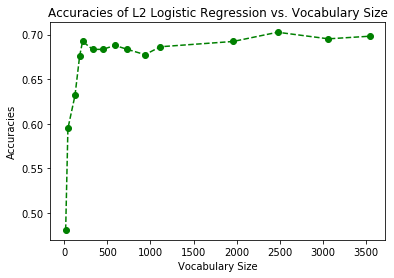

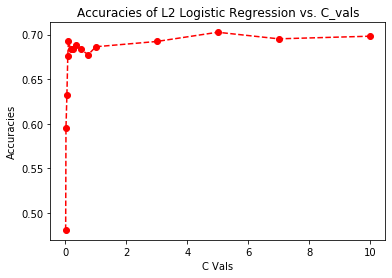

In [24]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    vectorizer = CountVectorizer(lowercase=True)
    train = vectorizer.fit_transform(train_data)
    sparse_dev = vectorizer.transform(dev_data)
    vocab = vectorizer.vocabulary_

    def part1():
        # L1 Loss - Log Reg
        l1_log_reg = LogisticRegression(penalty='l1',C=.62, multi_class="auto", solver='liblinear')
        l1_log_reg.fit(train,train_labels)
        l1_train_predict = l1_log_reg.predict(sparse_dev)
        accuracy = metrics.accuracy_score(dev_labels, l1_train_predict)   
        l1_coeffs = l1_log_reg.coef_.flatten()

        # L1 - Non zero learned weights
        l1_count = sum(l1_coeffs.astype(bool))
        print("L1 - Non zero learned weights")
        print("count: {0}".format(l1_count))
        print("Accuracy - L1 LogReg Model: {0}".format(accuracy))        
        print()


        # L2 Loss - Log Reg
        l2_log_reg = LogisticRegression(penalty='l2',C=.62, multi_class="auto", solver='liblinear')
        l2_log_reg.fit(train,train_labels)
        l2_train_predict = l2_log_reg.predict(sparse_dev)
        accuracy = metrics.accuracy_score(dev_labels, l2_train_predict)           
        l2_coeffs = l2_log_reg.coef_.flatten()

        # L2 - Non zero learned weights
        l2_count = sum(l2_coeffs.astype(bool))
        print("L2 - Non zero learned weights")
        print("count: {0}".format(l2_count ))
        print("Accuracy - L2 LogReg Model: {0}".format(accuracy))        
        print()
        
        return l1_log_reg.coef_
        
        
    def part2(l1_coeffs, tol_val=None):
        
        list_nonzero = []

        #All the indicies with non-zero values
        [list_nonzero.extend(list(np.nonzero(class_coef)[0])) for class_coef in l1_coeffs]        
        
        #Get only unique ones
        smaller_feature_indices = list(set(list(list_nonzero)))
        
        
        # Smaller vocab
        feat_names = vectorizer.get_feature_names()
        smaller_vocab = [feat_names[slot] for slot in smaller_feature_indices]
    
        small_vectorizer = CountVectorizer(lowercase=True, vocabulary=smaller_vocab)
        small_train = small_vectorizer.fit_transform(train_data)
        small_sparse_dev = small_vectorizer.transform(dev_data)
        small_vocab = small_vectorizer.vocabulary_
        
        
        if not tol_val:
            l2_small = LogisticRegression(penalty='l2',C=.62, multi_class="auto", solver='liblinear')
        else:
            l2_small = LogisticRegression(penalty='l2',C=.62
                                          , multi_class="auto", solver='liblinear', tol=tol_val)            
            
            
        l2_small.fit(small_train,train_labels)      
        l2_small_predict = l2_small.predict(small_sparse_dev)
        accuracy = metrics.accuracy_score(dev_labels, l2_small_predict)            
        
        if not tol_val:        
            print()
            print ("L2 with smaller vocab - Non zero learned weights")
            print("count: {0}".format(np.count_nonzero(l2_small.coef_)))
            print("Accuracy of smaller vocab L2 LogReg Model: {0}".format(accuracy))
            print()
        
        vocab_size = len(smaller_vocab)
        
        return [vocab_size, accuracy]


    def part3(tol_val =.015):
        c_vals = [0.01, 0.02, 0.05, 0.08, 0.1, 0.175, 0.25, 0.35, 0.5, 0.75, 1, 3, 5, 7, 10]
        vocab_sizes = []
        accuracies = []  
        
        for c_val in c_vals:

            vectorizer = CountVectorizer()
            train = vectorizer.fit_transform(train_data)
            l1_log_reg = LogisticRegression(penalty='l1', C=c_val, tol=tol_val, solver = 'liblinear')
            l1_log_reg.fit(train, train_labels)
            
            vocab_size,accuracy=part2(l1_log_reg.coef_,tol_val)
            
            vocab_sizes.append(vocab_size)
            accuracies.append(accuracy)       
            
        print()
        print("C Vals (for L1): {0}".format(c_vals))
        print()
        print("Vocab Sizes: {0}".format(vocab_sizes))
        print()        
        print("Accuracies: {0}".format(accuracies))
        print()        
        print()        
        print("The vocab sizes are varied by L1 regularization hyper-param C")
        print()
        print()   
        
        
        plt.figure(0)
        plt.plot(vocab_sizes, accuracies, 'go--')
        plt.xlabel("Vocabulary Size")
        plt.ylabel("Accuracies")
        plt.title("Accuracies of L2 Logistic Regression vs. Vocabulary Size")
        
        plt.figure(1)
        plt.plot(c_vals, accuracies, 'ro--')
        plt.xlabel("C Vals")
        plt.ylabel("Accuracies")
        plt.title("Accuracies of L2 Logistic Regression vs. C_vals")        
                
    
    part1 = part1()
    part2(part1)
    part3()
    
P6()

### Part 7:

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [15]:
def P7():
    
    log_reg = LogisticRegression(C=100, solver="liblinear", multi_class="auto")

    #Common vectorizer
    tfid_vectorizer = TfidfVectorizer()
    
    #TRAINING
    tfid_train = tfid_vectorizer.fit_transform(train_data)
    
    #DEVELOPMENT
    tfid_sparse_dev = tfid_vectorizer.transform(dev_data)

    
    log_reg.fit(tfid_train,train_labels)  
    tfid_predict = log_reg.predict(tfid_sparse_dev)
    f1_score_tfid = metrics.f1_score(dev_labels, tfid_predict, average="weighted")    
    print("TFIDVectorizer F1 Scores:{0}".format(f1_score_tfid))
    
    predicted_probs = log_reg.predict_proba(tfid_sparse_dev)
    
    r_ratios = []
    max_probs = []
    correct_probs = []
    correct_label_names=[]
    predicted_label_names=[]    
    documents = []
    
    for i in range(0,len(dev_labels)):
        
        max_prob = np.max(predicted_probs[i])
        correct_prob = predicted_probs[i][dev_labels[i]]
        
        predicted_label_name = newsgroups_train.target_names[np.argmax(predicted_probs[i])]
        correct_label_name = newsgroups_train.target_names[dev_labels[i]]
        
        r_ratio = max_prob/correct_prob
        
        
        document = dev_data[i]

        max_probs.append(max_prob)
        correct_probs.append(correct_prob)        
        r_ratios.append(r_ratio)
        correct_label_names.append(correct_label_name)
        predicted_label_names.append(predicted_label_name)
        documents.append(document)

        
    d = {'correct_label_name': correct_label_names, 'predicted_label_name':predicted_label_names, 'r_ratio': r_ratios,
         'max_prob': max_probs, 'correct_prob': correct_probs, 'document':documents}

    stats_table = pd.DataFrame(data=d)
    
    print()
    
    entry_count= 0
    for index, row in stats_table.sort_values(by=['r_ratio'], ascending=False).iterrows():
        
        if entry_count == 3:
            break

        print()
        print("Correct Label: "+ row['correct_label_name'])
        print("Predicted Label: " + row['predicted_label_name'])
        print()
        print("R-Ratio: {0}".format(row['r_ratio']))    
        print()
        print(row["document"])
        print()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print()
        entry_count+=1
        
        
    conf_mat = confusion_matrix(correct_label_names, predicted_label_names)        

    plt.show()        
        
        
    return [stats_table, conf_mat]


p7_df, p7_conf_mat = P7()



TFIDVectorizer F1 Scores:0.7597662427853104


Correct Label: talk.religion.misc
Predicted Label: comp.graphics

R-Ratio: 929.3569346206551

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copi

In [16]:
p7_df.sort_values(by=['r_ratio'], ascending=False).head()

,correct_label_name,predicted_label_name,r_ratio,max_prob,correct_prob,document
215,talk.religion.misc,comp.graphics,929.356935,0.993719,0.001069,I am pleased to announce that a *revised versi...
665,talk.religion.misc,comp.graphics,325.003814,0.979744,0.003015,Can anyone provide me a ftp site where I can o...
607,alt.atheism,talk.religion.misc,287.306723,0.695245,0.002420,"\nThe 24 children were, of course, killed by a..."
655,talk.religion.misc,alt.atheism,212.067692,0.974435,0.004595,In <1ren9a$94q@morrow.stanford.edu> salem@pang...
287,alt.atheism,talk.religion.misc,159.076241,0.964994,0.006066,With the Southern Baptist Convention convening...


**Notes:**

**TfidfVectorizer vs. CountVectorizer**

These are both are methods to convert text data into vectors of numerical values as representations for the text. 

With CountVectorizer we count the number of times a word appears in a document which can result in a bias towards the most frequent words, as their slot on the vector would be larger than the average word.(i.e, a document that is all the same word would strongly bias the data). As a result of the bias, CountVectorizer can overlook more rare words which could actually be very relevant for classification.

With TfidfVectorizer we look at an overall document weightage of a word. The inverse document frequency calculation adjusts for the scenarios where some words appear more frequently in general. For example, even though words like “we”, and “the” appear often in documents, since it appears often in a bunch of documents, they don't provide much useful information about what makes a document unique. Overall this helps us penalize super frequent words, and rather weights the word counts based on how often they appear throughout the documents.

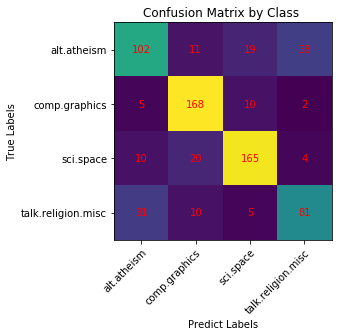

In [17]:
#Confusion Matrix Visualization: https://github.com/matplotlib/matplotlib/issues/14751
fig, ax = plt.subplots()
im = ax.imshow(p7_conf_mat)

ax.set_xticks(np.arange(len(newsgroups_train.target_names)))
ax.set_yticks(np.arange(len(newsgroups_train.target_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(newsgroups_train.target_names)
ax.set_yticklabels(newsgroups_train.target_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(newsgroups_train.target_names)):
    for j in range(len(newsgroups_train.target_names)):
        text = ax.text(j, i, p7_conf_mat[i, j],
                       ha="center", va="center", color="red")

ax.set_ylim(len(p7_conf_mat)-0.5, -0.5)
ax.set_xlabel("Predict Labels")
ax.set_ylabel("True Labels")
ax.set_ylim(len(p7_conf_mat)-0.5, -0.5)
ax.grid(False)
ax.set_title("Confusion Matrix by Class ")
plt.show()


In [18]:
print("Each column is just the count values")
p7_df.query('correct_label_name != predicted_label_name').groupby(by=['correct_label_name','predicted_label_name']).count()


Each column is just the count values


r_ratio  max_prob  correct_prob  \
correct_label_name predicted_label_name                                    
alt.atheism        comp.graphics              11        11            11   
                   sci.space                  19        19            19   
                   talk.religion.misc         33        33            33   
comp.graphics      alt.atheism                 5         5             5   
                   sci.space                  10        10            10   
                   talk.religion.misc          2         2             2   
sci.space          alt.atheism                10        10            10   
                   comp.graphics              20        20            20   
                   talk.religion.misc          4         4             4   
talk.religion.misc alt.atheism                31        31            31   
                   comp.graphics              10        10            10   
                   sci.space                   5         5             5   

                                         document  
correct_label_name predicted_label_name            
alt.atheism        comp.graphics               11  
                   sci.space                   19  
                   talk.religion.misc          33  
comp.graphics      alt.atheism                  5  
                   sci.space                   10  
                   talk.religion.misc           2  
sci.space          alt.atheism                 10  
                   comp.graphics               20  
                   talk.religion.misc           4  
talk.religion.misc alt.atheism                 31  
                   comp.graphics               10  
                   sci.space                    5

**Potential Issues**

Looking at our confusion matrix, we can see that there almost an even number of times in both ways (30-ish) where the model is confusing "religion" and "atheism". In addition we construct a grouped dataframe above for all the incorrect labelled scenarios.

We can see that across the board 'atheism' is the class category that has the highest incrorrect predictions. So lets take a look at some of the documents that have been misclassified.

In [19]:
atheism_sorted = p7_df.query('correct_label_name != predicted_label_name & correct_label_name == \'alt.atheism\'').sort_values(by=['r_ratio'], ascending=False)
atheism_sorted.head(10)

,correct_label_name,predicted_label_name,r_ratio,max_prob,correct_prob,document
607,alt.atheism,talk.religion.misc,287.306723,0.695245,0.002420,"\nThe 24 children were, of course, killed by a..."
287,alt.atheism,talk.religion.misc,159.076241,0.964994,0.006066,With the Southern Baptist Convention convening...
236,alt.atheism,sci.space,85.088278,0.579454,0.006810,"I think that _The_Transcedental_Temptation_, b..."
177,alt.atheism,sci.space,82.917537,0.795952,0.009599,\nThe CLIPPER initiative is an announcement by...
209,alt.atheism,sci.space,57.294291,0.768041,0.013405,TEST-- \n\n
465,alt.atheism,talk.religion.misc,50.698837,0.942219,0.018585,"As requested, here are some addresses of sourc..."
52,alt.atheism,talk.religion.misc,49.561228,0.902747,0.018215,"\nThe ""R Us"" thing is trademarked. I don't kn..."
181,alt.atheism,talk.religion.misc,48.570829,0.965774,0.019884,MC> Theory of Creationism: MY theistic view of...
141,alt.atheism,talk.religion.misc,33.250726,0.652600,0.019627,\n\n\nMuch of the Haight-Ashbury crowd probabl...
484,alt.atheism,sci.space,31.328611,0.828428,0.026443,"\nYes, unless the observer is at rest with res..."


In [20]:
entry_count = 0
for index, row in atheism_sorted.iterrows():
    if entry_count == 5:
        break
    print(row["predicted_label_name"])
    print()
    print(row["document"])       
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")    
    entry_count+=1

talk.religion.misc


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

~~~~~~~~~~~~~~~~~~~~~~~~~~~
talk.religion.misc

With the Southern Baptist Convention convening this June to consider
the charges that Freemasonry is incompatible with christianity, I thought
the following quotes by Mr. James Holly, the Anti-Masonic Flag Carrier,
would amuse you all...

     The following passages are exact quotes from "The Southern 
Baptist Convention and Freemasonry" by James L. Holly, M.D., President
of Mission and Ministry To Men, Inc., 550 N 10th St., Beaumont, TX 
77706. 
 
     The inside cover of the book states: "Mission & Ministry to Men, 
Inc. hereby grants permission for the reproduction of part or all of 
this booklet with two provisions: one, the material is not changed and
two, the source is identified." I have followed these provisions. 
  
     "Freemasonry is one of the allies of the Devil" Page

Ultimately some solutions to improve the model, could begin with applying preprocessing before running our TfidVectorizer and tokenizing our words. In theory we could play with all the various pre processing steps that I have included in Problem #5, this should help! In addition we can adjust the vocab size with minimum and/or maximum thresholds for word frequency using "min_df" and "max_df" as an option within TfidfVectorizer.

Our top 3 examples and the set of top 10 analyzed "atheism" documents that were incorrectly classifed, have the largest R ratios therefore are the cases where the model very confidentally made the wrong prediction. 

Interestingly enough in the cases that the correct label was **talk.religion.misc** but was predicted as **comp.graphics** both have what we can call "proper nouns" such as the words "Mormon", "ftp", "online", and "internet". For the "atheism" documents, we see similar patterns that the prediction was wrong because the documents had words/phrases such as "Jesus Christ", "The_Transcedental_Temptation", "government". These are unique words that might not be getting weighted appropriately. A possible solution is doing some analysis to figure out what these top unique words are, and increasing the weightage on these type of words relative to the correct class category. This would happen during the preprocessing and training stage and using our computed set list of proper nouns by category. Padding those words in to the document to increase the frequency of that words appearance. This way the model learns the weights with a slight bias, but nudged in the right direction.